In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
from tensorflow import set_random_seed

In [6]:
def plotROC(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve, area = {:.2}'.format(auc(fpr, tpr)))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
features = numpy.loadtxt('modifiedTraining.csv', delimiter=',')
labels = numpy.loadtxt('labels.csv', delimiter=',')

In [8]:
features.shape

(15420, 159)

In [9]:
labels.shape

(15420,)

In [295]:
trainX, testX, trainY, testY = train_test_split(features, labels, test_size=0.25, random_state=5)

In [296]:
trainingX, validX, trainingY, validY = train_test_split(trainX, trainY, test_size=0.25, random_state=5)

In [297]:
# using SMOTE for over-sampling
sm = SMOTE(kind='regular')

In [298]:
x, y = sm.fit_sample(trainingX, trainingY)

In [299]:
print('Number of fraudulent cases = {}\nNumber of true cases = {}'.format(sum(y[:] == 1), sum(y[:] == 0)))

Number of fraudulent cases = 8147
Number of true cases = 8147


In [300]:
# normalizing training data to zero mean and unit standard deviation
x -= numpy.mean(x, axis=0)
sd = numpy.std(x, axis=0)
sd[sd[:] == 0] = 1
x /= sd

In [301]:
ohe1 = OneHotEncoder()
ohe1.fit(y.reshape(-1,1))
transformedTrainingY = ohe1.transform(y.reshape(-1,1)).toarray()

In [302]:
testX -= numpy.mean(testX, axis=0)
sd = numpy.std(testX, axis=0)
sd[sd[:] == 0] = 1
testX /= sd

In [303]:
validX -= numpy.mean(validX, axis=0)
sd = numpy.std(validX, axis=0)
sd[sd[:] == 0] = 1
validX /= sd

In [306]:
callBack = EarlyStopping(patience=5)

In [309]:
sgd = SGD(lr=0.001, momentum=0.9)
set_random_seed(1)
numpy.random.seed(1)
model = Sequential()
model.add(Dense(60, activation='relu', input_shape=(159,)))
model.add(Dense(60, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.fit(x, transformedTrainingY, batch_size = 32, epochs=50, verbose=2, validation_data=(validX,ohe1.transform(validY.reshape(-1,1)).toarray()), callbacks=[callBack])
loss, accuracy = model.evaluate(testX, ohe1.transform(testY.reshape(-1,1)).toarray(), verbose=2)
predicted = model.predict(testX)
print('Test Loss = {} , Test Accuracy = {}, AUC = {}'.format(loss, accuracy, roc_auc_score(testY, predicted[:,1])))
# Confusion Matrix
print(confusion_matrix(testY, numpy.argmax(predicted, axis=1)))

Train on 16294 samples, validate on 2892 samples
Epoch 1/50
 - 4s - loss: 0.5766 - acc: 0.6907 - val_loss: 0.7016 - val_acc: 0.5899
Epoch 2/50
 - 2s - loss: 0.4343 - acc: 0.8008 - val_loss: 0.5850 - val_acc: 0.6680
Epoch 3/50
 - 2s - loss: 0.3663 - acc: 0.8423 - val_loss: 0.6017 - val_acc: 0.6743
Epoch 4/50
 - 2s - loss: 0.3131 - acc: 0.8743 - val_loss: 0.5448 - val_acc: 0.7089
Epoch 5/50
 - 2s - loss: 0.2662 - acc: 0.9022 - val_loss: 0.5562 - val_acc: 0.7133
Epoch 6/50
 - 2s - loss: 0.2244 - acc: 0.9218 - val_loss: 0.5251 - val_acc: 0.7459
Epoch 7/50
 - 2s - loss: 0.1894 - acc: 0.9380 - val_loss: 0.4906 - val_acc: 0.7711
Epoch 8/50
 - 2s - loss: 0.1599 - acc: 0.9502 - val_loss: 0.5482 - val_acc: 0.7524
Epoch 9/50
 - 2s - loss: 0.1336 - acc: 0.9606 - val_loss: 0.4472 - val_acc: 0.8074
Epoch 10/50
 - 2s - loss: 0.1134 - acc: 0.9696 - val_loss: 0.4791 - val_acc: 0.8015
Epoch 11/50
 - 2s - loss: 0.0957 - acc: 0.9756 - val_loss: 0.4833 - val_acc: 0.8043
Epoch 12/50
 - 2s - loss: 0.0816 - a

In [312]:
fpr, tpr, threshold = roc_curve(testY, predicted[:,1])

In [314]:
for val in list(zip(fpr, list(zip(tpr, threshold)))):
    print(val)

(0.0, (0.0, 1.999993))
(0.0002738975623116954, (0.0, 0.99999297))
(0.0010955902492467817, (0.0, 0.9998317))
(0.0010955902492467817, (0.00980392156862745, 0.99974364))
(0.001917282936181868, (0.00980392156862745, 0.9995486))
(0.001917282936181868, (0.0196078431372549, 0.99926466))
(0.0024650780608052587, (0.0196078431372549, 0.9991696))
(0.0024650780608052587, (0.024509803921568627, 0.9991217))
(0.002738975623116954, (0.024509803921568627, 0.9990012))
(0.002738975623116954, (0.029411764705882353, 0.9989729))
(0.0046562585592988225, (0.029411764705882353, 0.9984145))
(0.0046562585592988225, (0.03431372549019608, 0.9982632))
(0.006025746370857299, (0.03431372549019608, 0.9974849))
(0.006025746370857299, (0.0392156862745098, 0.9974045))
(0.007395234182415777, (0.0392156862745098, 0.99644655))
(0.007395234182415777, (0.04411764705882353, 0.99618715))
(0.008764721993974253, (0.04411764705882353, 0.99569345))
(0.008764721993974253, (0.049019607843137254, 0.99563676))
(0.010682004930156122, (0

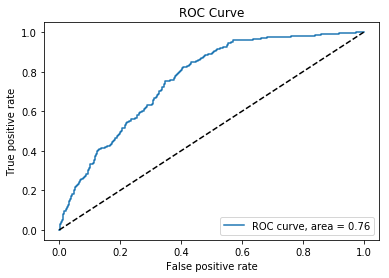

In [311]:
plotROC(fpr,tpr)

In [378]:
p = numpy.zeros(testY.shape)
p[predicted[:,1] > 0.3] = 1

In [379]:
yPredicted = numpy.argmax(predicted, axis=1)

In [380]:
confusion_matrix(testY, p)

array([[2879,  772],
       [  99,  105]])

In [381]:
precision_score(testY, p)

0.11972633979475485

In [382]:
recall_score(testY, p)

0.5147058823529411

In [383]:
f1_score(testY, p)

0.1942645698427382

In [384]:
accuracy_score(testY, p)

0.7740596627756161

In [307]:
help(model.fit)

Help on method fit in module keras.models:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, **kwargs) method of keras.models.Sequential instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    # Arguments
        x: Numpy array of training data.
            If the input layer in the model is named, you can also pass a
            dictionary mapping the input name to a Numpy array.
            `x` can be `None` (default) if feeding from
            framework-native tensors (e.g. TensorFlow data tensors).
        y: Numpy array of target (label) data.
            If the output layer in the model is named, you can also pass a
            dictionary mapping the output name to a Numpy array.
            `y` can be `None` (default) if feeding from
            framework-nat